In [3]:
!pip install --upgrade pip
!pip install --upgrade keras
!pip install -U -q tensorflow
#!pip show keras


  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [4]:
# Nämä importattiin simple audio mallissa.
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras import layers
from keras import models
from IPython import display



In [6]:
import sys

import numpy as np
from keras import Model
from keras import Layer

def import_model(filepath: str) -> Model:
    """Load model from file"""
    model: Model = models.load_model(filepath)
    return model

model = import_model('model_export.keras')
print(model.summary())



Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_24 (Resizing)               │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_24 (Normalization)     │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

None


In [7]:
def get_layer_weights(layer: str, model: Model) -> list[np.ndarray]:
    """Get layer weights from given model"""
    return model.get_layer(layer).get_weights()


def get_weights_shape(layer: list[np.ndarray]):
    tmp = []
    for i in layer:
        tmp.append(i.shape)
    return tmp



class DummyLayer(Layer):
    def __init__(self):
        super(DummyLayer, self).__init__()

    def call(self, inputs):
        return inputs

def get_reference_layer(layer: str, model: Model):
    """Split the model in to three parts start, layer and rest.

    Example:
    ```python
    model = import_model("../model/test_model.keras")
    (start, layer, end) = get_reference_layer("dense", model)

    result = start(waveform)
    layer_result = layer(result)
    print(layer_result)
    ```
    """
    modelStart = models.Sequential()
    selectedLayer: Layer
    modelEnd = models.Sequential()

    start = True
    l: Layer
    for l in model.layers:
        if l.name == layer:
            start = False
            selectedLayer = l
            continue
        if start:
            modelStart.add(l)
        else:
            modelEnd.add(l)

    if not len(modelStart.layers):
        modelStart.add(DummyLayer())
    if not len(modelEnd.layers):
        modelEnd.add(DummyLayer())

    modelStart.build(model.input_shape)
    modelEnd.build(selectedLayer.output.shape)
    return (modelStart, selectedLayer, modelEnd)



In [8]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram



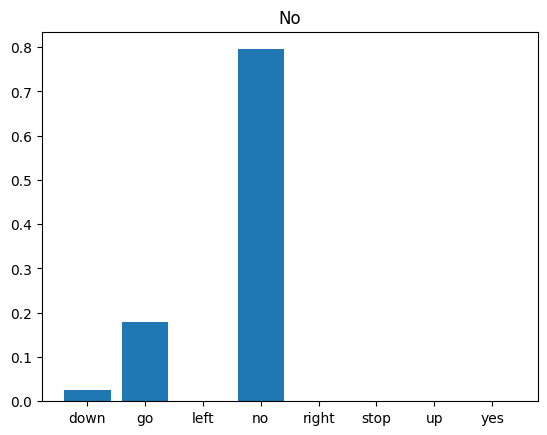

In [10]:
x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [19]:
# Tähän tehdään neuroverkon viimeinen laskenta toka dense_1 layerille

def listify(thing):
  print(type(thing))
  if isinstance(thing, np.ndarray):
    result = list(thing[0])
    print("Converted from numpy array")
  elif isinstance(thing, tf.Tensor):
    result = list(thing.numpy()[0])
    print("Converted from tensor")
  else:
    result = thing
  return result

def flatten(data):
  size = [len(data)] + [len(data[0])] + [len(data[0][0])]
  print(size)
  num = 0
  result = [0 for _ in range(size[0] * size[1] * size[2])]
  for i in range(size[0]):
    for j in range(size[1]):
      for k in range(size[2]):
        result[num] = data[i][j][k]
        num += 1
  return result


def matmul(data, weights, bias):
  result = [0 for _ in range(weights.shape[1])]

  # Muunnetaan kaikki sisään otettu tavallisiksi Python-listoiksi koska tässä taloudessa ei käytetä mitään
  # NumPyjä >:c
  '''
  if isinstance(data, np.ndarray):
    data_array = list(data[0])
    print("Converted from numpy array")
  elif isinstance(data, tf.Tensor):
    data_array = list(data.numpy()[0])
    print("Converted from tensor")
  else:
    data_array = data
  #weights = list(weights)
  '''

  print("Type: data ", type(data), ", weights ", type(weights))
  print("Sizes: i ", len(weights), ", j ", len(weights[0]), ", biases ", bias.shape, ", data ", len(data[0]))

  # Jokaisen neuronin tulos: aiemman neuronikerroksen (data_array) tulokset kerrottuina painoilla, + lopussa bias päälle
  for i in range(len(weights[0])):
    dot_product = 0
    for j in range(len(weights)):
      dot_product += data[j] * weights[j][i]
    print("j round ", i, " done")
    result[i] += bias[i] + dot_product

  #print("Vastaus 2:", result)
  #print("Type of result: ", type(result))
  return result


#def relu(data):
  #for i in range(data.shape[0]):


def dense1(data, weights, bias):
  result = matmul(data, weights, bias)
  result = np.array([result])
  result[result < 0] = 0
  #result = relu(result)
  return result


def dense2(data, weights, bias):
  result = matmul(data, weights, bias)
  return result

In [21]:
'''
Homma kannattaisi aloittaa verkon loppupäästä

'''

(start, layer, end) = get_reference_layer("flatten_24", model)
weights1 = get_layer_weights("dense_51",model)
weights2 = get_layer_weights("dense_52",model)

result = model(x)
print("Result: ", result)
layer_result = result

start_point = listify(start(x))
print(len(start_point), len(start_point[0]), len(start_point[0][0]))

w1 = listify(weights1[0])
b1 = listify(weights1[1])
w2 = listify(weights2[0])
b2 = listify(weights2[1])
step1 = flatten(start_point)
step2 = dense1(step1, w1, b1)
layer_oma_result = dense2(step2, w2, b2)
print("valmis tulos = ", layer_result)
print("oma tulos = ", layer_oma_result)

plt.figure(1)
plt.subplot(1,2,1)
plt.bar(x_labels, tf.nn.softmax(layer_result[0,:]))
plt.subplot(1,2,2)
plt.bar(x_labels, tf.nn.softmax(layer_oma_result[:]))
plt.show()


Result:  tf.Tensor(
[[ 2.2568939  4.191863  -3.872984   5.684949  -5.09859   -3.3092403
  -6.1663265 -2.7141771]], shape=(1, 8), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
Converted from tensor
14 14 64
<class 'numpy.ndarray'>
Converted from numpy array
<class 'numpy.ndarray'>


TypeError: 'numpy.float32' object is not iterable